In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import ensemble
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
import sklearn.dummy as dummy
import csv
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = None
pd.options.display.max_columns = None

%matplotlib inline

## File Imports

In [2]:
test_file_excel = 'Test Data.xlsx'

In [3]:
test = pd.read_excel(test_file_excel)

In [4]:
test.shape

(536, 33)

In [5]:
test.columns

Index(['Make', 'Model', 'Year', 'Condition_Trim (description)', 'MSRP',
       'Body type', 'Length (in)', 'Width (in)', 'Height (in)',
       'Wheelbase (in)', 'Curb weight (lbs)', 'Cylinders', 'Engine size (l)',
       'Horsepower (HP)', 'Horsepower (rpm)', 'Torque (ft-lbs)',
       'Torque (rpm)', 'Drive type', 'Transmission', 'Engine type',
       'Fuel type', 'Fuel tank capacity (gal)', 'Combined MPG',
       'EPA mileage (mpg)', 'Range (miles)', 'Domestic / imported',
       'Country of origin', 'Car classification',
       'Platform code / generation number', 'Date added', 'New make',
       'New model', 'New year'],
      dtype='object')

## 1. A unique list of Trim values (column d) separated from condition and description

In [6]:
trial = test['Condition_Trim (description)'][0]

In [7]:
trial

'USED_325i Rwd 4dr Sedan (2.5L 6cyl 5M)'

In [8]:
trial.split('_')[1].split('(')[0].strip() # takes the string after the condition and before the description

'325i Rwd 4dr Sedan'

In [9]:
test['Condition_Trim (description)'].isnull().sum()

0

In [10]:
def get_trim(x):
    
    # Trim and description are after the condition_ so grab whatevers after the _ if it exists
    temp = x.split('_')
    if len(temp) == 2:
        x = temp[1]
    elif len(temp) > 2:
        return None # preferrably log or raise error here
    
    # description is specified by the parens, so grab whatevers before the parens if it exists
    temp = x.split('(')
    if len(temp) == 2:
        x = temp[0]
    elif len(temp) > 2:
        return None # preferrably log or raise error here
    
    return x.strip() # remove white space

In [11]:
get_trim(trial)

'325i Rwd 4dr Sedan'

In [12]:
trim = test['Condition_Trim (description)'].apply(lambda x: get_trim(x))

In [13]:
trim.isnull().sum() # check for Null values, where there's excess _ or (

0

In [14]:
unique_trim = trim.unique()

In [15]:
with open('unique_trim.csv', 'w') as outfile:
    wtr = csv.writer(outfile, delimiter=',', lineterminator='\n')
    for x in unique_trim: 
        wtr.writerow([x])


## 2. An array with average MSRP by Make and Year

In [16]:
test['MSRP'].isnull().sum()

152

In [17]:
make_year_avg_msrp = test.groupby(['Make','Year'])['MSRP'].mean()

In [18]:
make_year_avg_msrp = make_year_avg_msrp.fillna(0)

In [19]:
make_year_avg_msrp

Make    Year
BMW     1990        0.000000
        1992        0.000000
        1994        0.000000
        1996        0.000000
        1998        0.000000
        2000        0.000000
        2002    35735.000000
        2004    37112.500000
        2006    39390.909091
        2008    42943.333333
        2010    44212.500000
        2012    47746.428571
        2014    40230.769231
        2016    42665.384615
        2018    49296.153846
        2020    48375.000000
Ford    1990        0.000000
        1995        0.000000
        2000        0.000000
        2005    29333.645833
        2010    34036.078431
        2015    39443.625000
        2020    44693.409091
Toyota  2001    19995.000000
        2002    19995.000000
        2003    19995.000000
        2004    20295.000000
        2005    21275.000000
        2006    21725.000000
        2007    22622.500000
        2008    22715.000000
        2009    23215.000000
        2010    24534.000000
        2011    25254.000000
 

In [20]:
make_year_avg_msrp.to_csv('make_year_avg_msrp.csv')

## 3. Pick at least two Scikit-learn classification models, set up each models using the provided training data with the idea of classifying future data by “Make”. Compare and contrast the results, then provide a recommendation on which model you prefer. 

### Replace Nulls

In [21]:
test.isnull().sum()

Make                                   0
Model                                  0
Year                                   0
Condition_Trim (description)           0
MSRP                                 152
Body type                              0
Length (in)                            0
Width (in)                             0
Height (in)                            0
Wheelbase (in)                         0
Curb weight (lbs)                     67
Cylinders                              0
Engine size (l)                        0
Horsepower (HP)                        2
Horsepower (rpm)                       2
Torque (ft-lbs)                       40
Torque (rpm)                          40
Drive type                             0
Transmission                          26
Engine type                            0
Fuel type                              0
Fuel tank capacity (gal)               0
Combined MPG                           4
EPA mileage (mpg)                      6
Range (miles)   

In [22]:
na_cols = ['Trim','Model','MSRP','Curb weight (lbs)','Horsepower (HP)',
           'Horsepower (rpm)','Torque (ft-lbs)','Torque (rpm)',
           'Transmission','Combined MPG','EPA mileage (mpg)']

In [23]:
na_num_cols = ['MSRP','Curb weight (lbs)','Horsepower (HP)',
           'Horsepower (rpm)','Torque (ft-lbs)','Torque (rpm)',
           'Combined MPG']

In [24]:
na_str_cols = ['Transmission','EPA mileage (mpg)']

In [25]:
test['Trim'] = trim

In [26]:
test[na_cols].groupby('Trim').transform(lambda x: x.fillna(x.mean())).isnull().sum()

MSRP                 118
Curb weight (lbs)     17
Horsepower (HP)        0
Horsepower (rpm)       0
Torque (ft-lbs)        0
Torque (rpm)           0
Combined MPG           0
dtype: int64

In [27]:
test[na_num_cols] = test[na_cols].groupby('Trim').transform(lambda x: x.fillna(x.mean()))

In [28]:
test[na_cols].groupby('Model').transform(lambda x: x.fillna(x.mean())).isnull().sum()

MSRP                 0
Curb weight (lbs)    0
Horsepower (HP)      0
Horsepower (rpm)     0
Torque (ft-lbs)      0
Torque (rpm)         0
Combined MPG         0
dtype: int64

In [29]:
test[na_num_cols] = test[na_cols].groupby('Model').transform(lambda x: x.fillna(x.mean()))

In [30]:
test.isnull().sum()

Make                                   0
Model                                  0
Year                                   0
Condition_Trim (description)           0
MSRP                                   0
Body type                              0
Length (in)                            0
Width (in)                             0
Height (in)                            0
Wheelbase (in)                         0
Curb weight (lbs)                      0
Cylinders                              0
Engine size (l)                        0
Horsepower (HP)                        0
Horsepower (rpm)                       0
Torque (ft-lbs)                        0
Torque (rpm)                           0
Drive type                             0
Transmission                          26
Engine type                            0
Fuel type                              0
Fuel tank capacity (gal)               0
Combined MPG                           0
EPA mileage (mpg)                      6
Range (miles)   

In [31]:
test[na_cols].groupby('Trim').transform(lambda x: x.ffill().bfill()).isnull().sum()

Model                 0
MSRP                  0
Curb weight (lbs)     0
Horsepower (HP)       0
Horsepower (rpm)      0
Torque (ft-lbs)       0
Torque (rpm)          0
Transmission         14
Combined MPG          0
EPA mileage (mpg)     0
dtype: int64

In [32]:
test[na_str_cols] = test[['Trim','Transmission','EPA mileage (mpg)']].groupby('Trim').transform(lambda x: x.ffill().bfill())

In [33]:
test[na_cols].groupby('Model').transform(lambda x: x.ffill().bfill()).isnull().sum()

Trim                 0
MSRP                 0
Curb weight (lbs)    0
Horsepower (HP)      0
Horsepower (rpm)     0
Torque (ft-lbs)      0
Torque (rpm)         0
Transmission         0
Combined MPG         0
EPA mileage (mpg)    0
dtype: int64

In [34]:
test[na_str_cols] = test[['Model','Transmission','EPA mileage (mpg)']].groupby('Model').transform(lambda x: x.ffill().bfill())

In [35]:
# filled_df is columns nafilled and excluding new make, year, model as they're predominantly null
# filled_df = test[['Make','Model', 'Year',  'MSRP',
#        'Body type', 'Length (in)', 'Width (in)', 'Height (in)',
#        'Wheelbase (in)', 'Curb weight (lbs)', 'Cylinders', 'Engine size (l)',
#        'Horsepower (HP)', 'Horsepower (rpm)', 'Torque (ft-lbs)',
#        'Torque (rpm)', 'Drive type', 'Transmission', 'Engine type',
#        'Fuel type', 'Fuel tank capacity (gal)', 'Combined MPG',
#        'EPA mileage (mpg)', 'Range (miles)', 'Domestic / imported',
#        'Country of origin', 'Car classification',
#        'Platform code / generation number', 'Date added', 'Trim']]

In [36]:
def plot_all(df):
    # IN:  dataframe
    # OUT: draws histograms of every column
    dfx = df.copy()
    
    pos = 1
    plt.figure(figsize=(15,175))
    
    for col in dfx.columns:
        
        if (not isinstance(dfx[col][0], str)):
            not_nans = [x for x in dfx[col] if str(x) != 'nan']
            
            plt.subplot(42,3,pos)
            plt.title(col)
            
            plt.hist(not_nans,bins=25)
            
            pos += 1

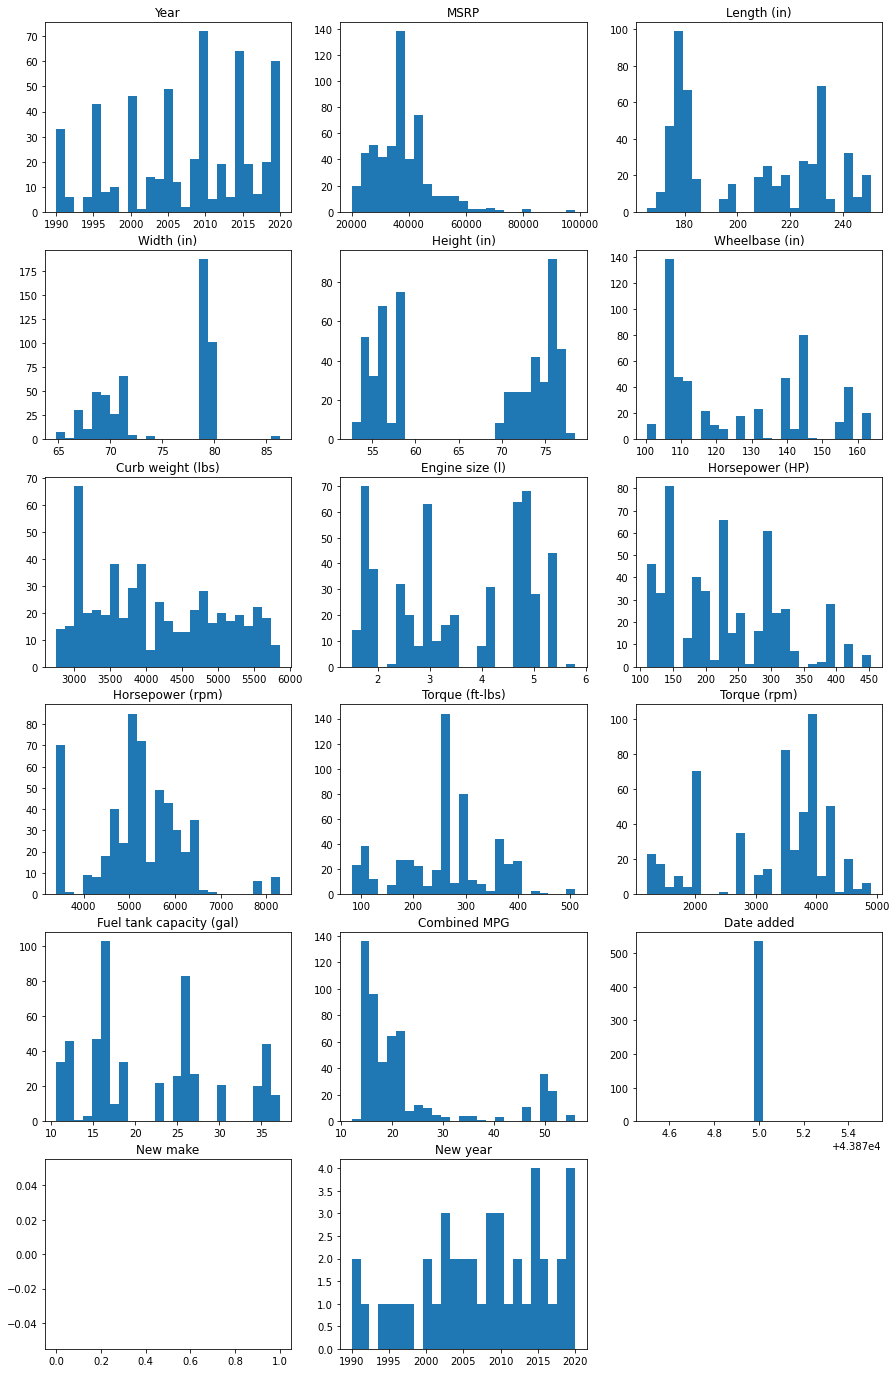

In [37]:
plot_all(test)

### Train Test Split

In [38]:
# We don't include  'New make', 'New model', 'New year' as they are nearly completely NaN
# We also don't include epa mileage or range (miles) as combined milage is a derivative of epa
# and Range is a derivative of epa and capacity. 
# We could have used epa instead of combine, however combined was already clean
# We also don't include condition_trim as we have trim already separated out, and condition shouldn't show model
# Including Trim is going to overfit us so it's been removed, this isn't trying to be a dictionary of trim to make
features = ['Model', 'Year', 'MSRP',
       'Body type', 'Length (in)', 'Width (in)', 'Height (in)',
       'Wheelbase (in)', 'Curb weight (lbs)', 'Cylinders', 'Engine size (l)',
       'Horsepower (HP)', 'Horsepower (rpm)', 'Torque (ft-lbs)',
       'Torque (rpm)', 'Drive type', 'Transmission', 'Engine type',
       'Fuel type', 'Fuel tank capacity (gal)', 'Combined MPG',
       'Domestic / imported',
       'Country of origin', 'Car classification',
       'Platform code / generation number', 'Date added']

In [39]:
X = test[features]
Y = preprocessing.OrdinalEncoder().fit(test.loc[:,['Make']]).transform(test.loc[:,['Make']])

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8, random_state=9)

### Preprocessing

In [41]:
categorical_features = ['Model','Body type','Cylinders',
                        'Drive type','Transmission','Engine type','Fuel type',
                        'Domestic / imported','Country of origin','Car classification',
                        'Platform code / generation number']

In [42]:
numerical_features = features = ['Year', 'MSRP',
       'Length (in)', 'Width (in)', 'Height (in)',
       'Wheelbase (in)', 'Curb weight (lbs)',  'Engine size (l)',
       'Horsepower (HP)', 'Horsepower (rpm)', 'Torque (ft-lbs)',
       'Torque (rpm)',  'Fuel tank capacity (gal)', 'Combined MPG',
        'Date added']

In [43]:
preprocess = make_column_transformer(
    (preprocessing.StandardScaler(), numerical_features),
    (preprocessing.OneHotEncoder(), categorical_features))

### Models

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [45]:
# random forest
rf_cl = make_pipeline(
        preprocess,
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1))
rf_cl.fit(X_train, y_train.ravel())
print("random forest classifier score: %f" % rf_cl.score(X_test, y_test))

random forest classifier score: 1.000000


In [46]:
# KN
kn_cl = make_pipeline(
        preprocess,
        KNeighborsClassifier(3))
kn_cl.fit(X_train, y_train.ravel())
print("KNeighbors classifier score: %f" % kn_cl.score(X_test, y_test))

KNeighbors classifier score: 1.000000


In [47]:
# naive bayes
nb_cl = make_pipeline(
        preprocess,
        GaussianNB())
nb_cl.fit(X_train, y_train.ravel())
print("naive bayes classifier score: %f" % nb_cl.score(X_test, y_test))

naive bayes classifier score: 1.000000


In [48]:
# dummy classifier
dummy_clf = dummy.DummyClassifier(strategy='most_frequent',random_state=10,constant = 1)
dummy_clf.fit(X_train, y_train)
print("dummy classifier score: %f" % dummy_clf.score(X_test, y_test))

dummy classifier score: 0.472222


##### trying to make this more difficult

In [49]:
# not including categorical scalers also means that im dropping them
# trying this because among the categorical features there are many that can replace make
preprocess = make_column_transformer(
    (preprocessing.StandardScaler(), numerical_features))


In [50]:
# random forest
rf_cl = make_pipeline(
        preprocess,
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1))
rf_cl.fit(X_train, y_train.ravel())
print("random forest classifier score: %f" % rf_cl.score(X_test, y_test.ravel()))

random forest classifier score: 1.000000


In [51]:
# KN
kn_cl = make_pipeline(
        preprocess,
        KNeighborsClassifier(3))
kn_cl.fit(X_train, y_train.ravel())
print("KNeighbors classifier score: %f" % kn_cl.score(X_test, y_test.ravel()))

KNeighbors classifier score: 1.000000


In [52]:
# naive bayes
nb_cl = make_pipeline(
        preprocess,
        GaussianNB())
nb_cl.fit(X_train, y_train.ravel())
print("naive bayes classifier score: %f" % nb_cl.score(X_test, y_test.ravel()))

naive bayes classifier score: 0.981481


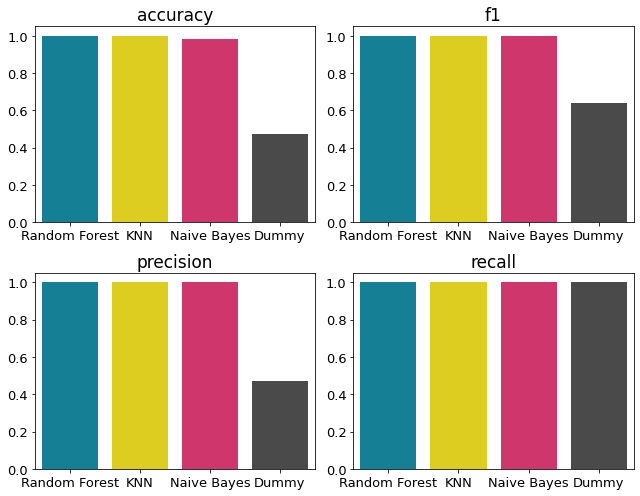

In [53]:
df_scores = pd.DataFrame()
models = [rf_cl, kn_cl, nb_cl, dummy_clf]
model_name = ['random forest','KNN','Naive Bayes', 'Dummy']

for i, model in enumerate(models):
 
    y_predict = model.predict(X_test)
    
    p,r,f1,support = precision_recall_fscore_support(y_test,y_predict,beta=1)
    
    acc = (y_test.ravel() == y_predict).sum() / y_test.ravel().shape[0]
    
    scores = {'model':model_name[i],'accuracy':acc,'precision':p[1],'recall':r[1],'f1':f1[1]}
    df_scores = df_scores.append(pd.DataFrame(data=scores,index=[0]))
    
df_scores.reset_index(drop=True,inplace=True)
flatui = ['#008DAB','#FCE700','#E81D64','#4A4A4A']
cpal = sns.color_palette(flatui)
plt.figure(figsize=(9,7))
i = 1
yticks = [[0,0.5,1.0],[0,0.25,0.5,0.75],[0,0.5,1],[0,0.2,0.4,0.6],[0,0.25,0.5,0.75]]


for metric,yt in zip(['accuracy','f1','precision','recall'],yticks):

    sfont = 13
    bfont = 17
    plt.subplot(2,2,i)
    sns.barplot(x='model',y=metric,data=df_scores,palette=cpal)
    plt.xlabel('')
    plt.ylabel('',fontsize=sfont)
    plt.xticks(np.arange(4),['Random Forest','KNN','Naive Bayes', 'Dummy'],fontsize=sfont)
    #plt.yticks([0,0.5,1],fontsize=sfont)
    plt.yticks(fontsize=sfont)
    plt.title(metric,fontsize=bfont)
    #plt.xlim(-0.5,3.5)
    i+=1
    
plt.tight_layout()

The models chosen for comparison are Random Forest (rf) and K-Nearest Neighbors (knn). Both were perfectly accurate even when categorical variables were removed, so comparing them in relation to this dataset and classification goal is difficult. If including categorical features the better choice would be to use a rf, as decision trees are great for categorical variables and they also scale better to the higher dimensionality of the dataset. If just using numerical features, knn would become a stronger model because we've reduced the dimensionality, and the nearest neighbors algorithm does better when features are continuous as distances are less likely to be equal. 

Naive bayes was added as a suboptimal classifier as our features are not independent, and we got our first bit of error when we removed categories. A dummy classifier was included as well to give a baseline for what our models should be better than.

Overall I'd prefer the Random Forest because it allows better usage of all of our features as well as being well easier to interpret if we needed to explain the model.